# CNN을 이용한 당뇨 데이터 분류 + 전이학습 

## 1. 데이터 불러오기

In [80]:
# 데이터 불러오기
import pandas as pd

df = pd.read_csv(r"C:\Users\DoHyeonjik\GachonUniv\3-2\datasets\DL\diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [81]:
# 데이터 살펴보기
print(df.shape)
# 행 특성 보기
print(df.columns)

(768, 9)
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


열 768개 x (특성 8개 + 레이블 1개)

레이블 : 1이면 당뇨 O

## 2. 데이터 전처리

In [82]:
# a. 데이터와 레이블 분리
df_data = df.drop('Outcome', axis=1)
print(df_data.shape)

df_label = df['Outcome']
print(df_label.shape)

# 데이터 정규화
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df_data = ss.fit_transform(df_data)

(768, 8)
(768,)


In [83]:
# b. 훈련 데이터와 테스트 데이터 분리
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_data, df_label, test_size=0.25, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(576, 8) (576,)
(192, 8) (192,)


In [84]:
# c. CNN 사용을 위해 3차원 데이터로의 변경을 위한 split_sequence 사용
# 1) 데이터와 레이블 병합
import numpy as np

y_train = np.array(y_train)
train_set = np.c_[x_train, y_train]

y_test = np.array(y_test)
test_set = np.c_[x_test, y_test]

In [85]:
# 2) split_sequence
from collections import Counter

def split_sequence(sequences, n_steps):
    x,y = list(), list()
    for i in range(len(sequences)):
        end_idx = i + n_steps
        if end_idx > len(sequences):
            break
        seq_x = sequences[i:end_idx, :-1]
        seq_y_values = sequences[i:end_idx, -1]

        most_commom_values = Counter(seq_y_values).most_common(1)[0][0]
        x.append(seq_x)
        y.append(most_commom_values)

    return np.array(x), np.array(y)


In [86]:
# 3) split_sequence 적용
x_train, y_train = split_sequence(train_set, 5)
x_test, y_test = split_sequence(test_set, 5)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(572, 5, 8) (572,)
(188, 5, 8) (188,)


In [87]:
# 4) 원핫인코딩
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(572, 2)
(188, 2)


In [88]:
# 5) 채널 하나 추가
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
print(x_train.shape)
print(x_test.shape)

(572, 5, 8, 1)
(188, 5, 8, 1)


## 3. 모델 생성

In [89]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(5,8,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

C:\Users\DoHyeonjik\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 3, 6, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

## 4. 훈련

In [90]:
history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=True)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7402 - loss: 0.5825 - val_accuracy: 0.7414 - val_loss: 0.6447
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7996 - loss: 0.5222 - val_accuracy: 0.7414 - val_loss: 0.5880
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8272 - loss: 0.4612 - val_accuracy: 0.7414 - val_loss: 0.5734
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8072 - loss: 0.4469 - val_accuracy: 0.7414 - val_loss: 0.5538
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7799 - loss: 0.4790 - val_accuracy: 0.7414 - val_loss: 0.5475
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8118 - loss: 0.4476 - val_accuracy: 0.7414 - val_loss: 0.5399
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8212 - loss: 0.4369 - val_accuracy: 0.7414 - val_loss: 0.5332
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8156 - loss: 0.4380 - val_accuracy: 0.7586 - val_loss

## 5. 결과

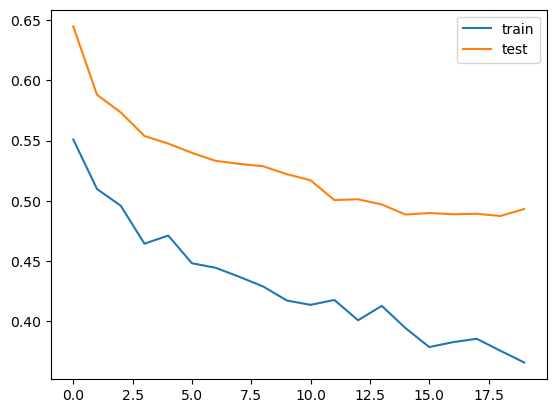

In [91]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="test")
plt.legend()

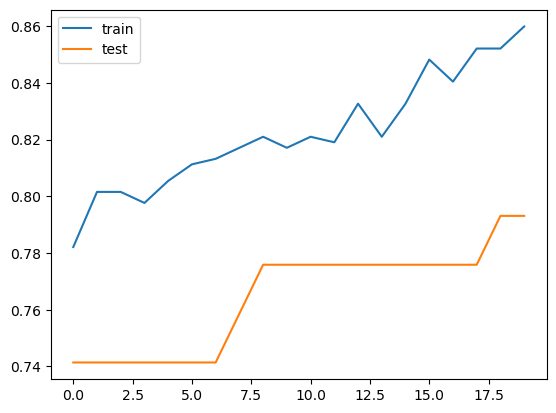

In [92]:
plt.plot(history.history['accuracy'], label="train")
plt.plot(history.history['val_accuracy'], label="test")
plt.legend()

In [93]:
print(model.evaluate(x_train, y_train))
print(model.evaluate(x_test, y_test))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8642 - loss: 0.3233 
[0.3589162826538086, 0.8444055914878845]
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - loss: 0.4430 
[0.4315485954284668, 0.813829779624939]


## 6. 모델추출

In [94]:
base_loss, base_accuracy = model.evaluate(x_test, y_test)

model_file=r'C:\Users\DoHyeonjik\Desktop\model.h5'

keras.models.save_model(model, model_file, include_optimizer=False)
print('model saved at ', model_file)
print('Base Acccuracy>{:f}'.format(base_accuracy))
print('Base Loss>{:2f}'.format(base_loss))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8173 - loss: 0.4430 


model saved at  C:\Users\DoHyeonjik\Desktop\model.h5
Base Acccuracy>0.813830
Base Loss>0.431549


# 7. 전이 학습 및 미세 조정

In [95]:
# 모델 불러오기
base_model = keras.models.load_model(model_file)

In [97]:
# 모델 컴파일 및 평가
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
base_model.summary()
base_model.evaluate(x_test, y_test)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 3, 6, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.8173 - loss: 0.4430  


[0.4315485954284668, 0.813829779624939]

In [103]:
# 전이 학습 시작
base_model.trainable = False

def remove_last_layers(model, num_layers_to_remove):
    model_layers = model.layers[:-num_layers_to_remove]
    print(model_layers)
    new_model = keras.models.Sequential(model_layers)
    return new_model

new_model = remove_last_layers(base_model, 1)

new_model.add(Dense(2, activation='softmax'))
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

display_layers= [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

[<Conv2D name=conv2d_9, built=True>, <MaxPooling2D name=max_pooling2d_7, built=True>, <Flatten name=flatten_7, built=True>, <Dense name=dense_16, built=True>, <Dropout name=dropout_6, built=True>]


,Layer Type,Layer Name,Layer Trainable
0,"<Conv2D name=conv2d_9, built=True>",conv2d_9,False
1,"<MaxPooling2D name=max_pooling2d_7, built=True>",max_pooling2d_7,False
2,"<Flatten name=flatten_7, built=True>",flatten_7,False
3,"<Dense name=dense_16, built=True>",dense_16,False
4,"<Dropout name=dropout_6, built=True>",dropout_6,False
5,"<Dense name=dense_20, built=False>",dense_20,True


In [100]:
history2 = new_model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.6502 - loss: 0.6173 - val_acc: 0.7241 - val_loss: 0.5926
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8127 - loss: 0.5200 - val_acc: 0.7414 - val_loss: 0.5617
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7964 - loss: 0.4674 - val_acc: 0.7414 - val_loss: 0.5523
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7879 - loss: 0.4556 - val_acc: 0.7414 - val_loss: 0.5466
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8014 - loss: 0.4830 - val_acc: 0.7414 - val_loss: 0.5423
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8125 - loss: 0.4208 - val_acc: 0.7414 - val_loss: 0.5375
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8215 - loss: 0.4342 - val_acc: 0.7586 - val_loss: 0.5305
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8074 - loss: 0.4064 - val_acc: 0.7759 - val_loss: 0.5260
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8256 - loss:

In [104]:
#미세조정을 위해 동결 해제
base_model.trainable= True
new_model.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')

display_layers= [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,"<Conv2D name=conv2d_9, built=True>",conv2d_9,True
1,"<MaxPooling2D name=max_pooling2d_7, built=True>",max_pooling2d_7,True
2,"<Flatten name=flatten_7, built=True>",flatten_7,True
3,"<Dense name=dense_16, built=True>",dense_16,True
4,"<Dropout name=dropout_6, built=True>",dropout_6,True
5,"<Dense name=dense_20, built=False>",dense_20,True


In [105]:
history3 = new_model.fit(x_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=True_

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.6797 - loss: 0.6025 - val_acc: 0.7414 - val_loss: 0.6153
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.7858 - loss: 0.5120 - val_acc: 0.7414 - val_loss: 0.5405
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8307 - loss: 0.4267 - val_acc: 0.7414 - val_loss: 0.5274
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8133 - loss: 0.4234 - val_acc: 0.7414 - val_loss: 0.5217
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8133 - loss: 0.4215 - val_acc: 0.8103 - val_loss: 0.5072
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8252 - loss: 0.4104 - val_acc: 0.7931 - val_loss: 0.4944
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.8533 - loss: 0.3555 - val_acc: 0.7931 - val_loss: 0.4858
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8280 - loss: 0.4085 - val_acc: 0.7931 - val_loss: 0.4854
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.8350 - los

_________________
### 전이학습의 정확한 확인을 위해 훈련데이터 일부 수정(10/05)
기존 모델을 훈련할 때의 데이터와 조금이라도 다르게 해보고 싶어서 훈련과 테스트 데이터를 조금 바꿈
 

In [116]:
# 기존의 세트와 다른 시드로 분리
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_data, df_label, test_size=0.25, random_state=20)
print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

# split_sequence
y_train2 = np.array(y_train2)
train_set2 = np.c_[x_train2, y_train2]

y_test2 = np.array(y_test2)
test_set2 = np.c_[x_test2, y_test2]

x_train2, y_train2 = split_sequence(train_set2, 5)
x_test2, y_test2 = split_sequence(test_set2, 5)

print(x_train2.shape)
print(x_test2.shape)

# 원핫인코딩
y_train2 = to_categorical(y_train2)
y_test2 = to_categorical(y_test2)
print(y_train2.shape, y_test2.shape)

# 채널 값 추가
x_train2 = np.expand_dims(x_train2, axis=-1)
x_test2 = np.expand_dims(x_test2, axis=-1)
print(x_train2.shape)

(576, 8)
(576,)
(192, 8)
(192,)
(572, 5, 8)
(188, 5, 8)
(572, 2) (188, 2)
(572, 5, 8, 1)


In [117]:
# 기존의 모델 새로 로딩
base_model2 = keras.models.load_model(model_file)
# 기존 모델 컴파일
base_model2.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')
base_model2.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 3, 6, 32)            │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 3, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# 전이학습 시작
base_model2.trainable= False

new_model2 = remove_last_layers(base_model, 1)

new_model2.add(Dense(2, activation='softmax'))
new_model2.compile(optimizer='adam', metrics=['acc'], loss='categorical_crossentropy')

display_layers= [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


[<Conv2D name=conv2d_9, built=True>, <MaxPooling2D name=max_pooling2d_7, built=True>, <Flatten name=flatten_7, built=True>, <Dense name=dense_16, built=True>, <Dropout name=dropout_6, built=True>]


,Layer Type,Layer Name,Layer Trainable
0,"<Conv2D name=conv2d_9, built=True>",conv2d_9,True
1,"<MaxPooling2D name=max_pooling2d_7, built=True>",max_pooling2d_7,True
2,"<Flatten name=flatten_7, built=True>",flatten_7,True
3,"<Dense name=dense_16, built=True>",dense_16,True
4,"<Dropout name=dropout_6, built=True>",dropout_6,True
5,"<Dense name=dense_20, built=True>",dense_20,True


In [121]:
history4 = new_model2.fit(x_train2, y_train2, epochs=20, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.5251 - loss: 0.7271 - val_acc: 0.8793 - val_loss: 0.3837
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7473 - loss: 0.5665 - val_acc: 0.8793 - val_loss: 0.4160
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7391 - loss: 0.5844 - val_acc: 0.8793 - val_loss: 0.4055
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7340 - loss: 0.5450 - val_acc: 0.8793 - val_loss: 0.3762
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7673 - loss: 0.5183 - val_acc: 0.8621 - val_loss: 0.3966
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7464 - loss: 0.5256 - val_acc: 0.8621 - val_loss: 0.3875
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7462 - loss: 0.5145 - val_acc: 0.8448 - val_loss: 0.4015
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7813 - loss: 0.4983 - val_acc: 0.8448 - val_loss: 0.4057
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7678 - loss:

In [122]:
# 미세조정 시작
base_model2.trainable= True
new_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

display_layers= [(layer, layer.name, layer.trainable) for layer in new_model.layers]
pd.DataFrame(display_layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


,Layer Type,Layer Name,Layer Trainable
0,"<Conv2D name=conv2d_9, built=True>",conv2d_9,True
1,"<MaxPooling2D name=max_pooling2d_7, built=True>",max_pooling2d_7,True
2,"<Flatten name=flatten_7, built=True>",flatten_7,True
3,"<Dense name=dense_16, built=True>",dense_16,True
4,"<Dropout name=dropout_6, built=True>",dropout_6,True
5,"<Dense name=dense_20, built=True>",dense_20,True


In [124]:
history5= new_model2.fit(x_train2, y_train2, epochs=20, batch_size=32, validation_split=0.1, shuffle=True)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - acc: 0.7929 - loss: 0.4279 - val_acc: 0.8276 - val_loss: 0.4210
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7910 - loss: 0.4286 - val_acc: 0.8276 - val_loss: 0.4049
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8062 - loss: 0.4096 - val_acc: 0.8276 - val_loss: 0.4062
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8015 - loss: 0.4197 - val_acc: 0.8103 - val_loss: 0.3981
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8303 - loss: 0.4125 - val_acc: 0.8276 - val_loss: 0.3870
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8333 - loss: 0.3941 - val_acc: 0.8276 - val_loss: 0.3799
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8125 - loss: 0.3863 - val_acc: 0.8276 - val_loss: 0.3979
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8444 - loss: 0.3647 - val_acc: 0.8276 - val_loss: 0.3885
Epoch 9/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8354 - loss:

In [ ]:
# 똑같이 잘 작동하는 것을 볼 수 있다.
# 사실 중간중간 shuffle 때문에 이렇게 하는거랑 안하는 거랑 차이가 있는지는 모르겠음
# 적어도 모델이 더 일반화 될것이라고는 에측함